# TREE-BASED MODELS

## 1. Load libraries

In [ ]:
# Notebook configuration
import six
import sys
from IPython.display import Image
sys.modules['sklearn.externals.six'] = six

# Basic
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

# Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Matplotlib configuration
# %matplotlib inline
# plt.style.use('seaborn-white')

## 2. Plotting trees

Let's start by defining a function to plot the different tree models

In [ ]:
def print_tree(estimator, features, class_names=None, filled=True):

    '''
      Objective:

        - Generate a visualization of a decision tree model.

      Input:

        - estimator: The decision tree estimator/model.
        - features: List of feature names.
        - class_names (optional): List of class names for the target variable.
        - filled (optional, default=True): Boolean indicating whether to color nodes.

      Output:

        - A visual representation (graph) of the decision tree.
    '''
    tree = estimator
    names = features
    color = filled
    classn = class_names
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

Next, we'll visualize regression trees. Initially, we load the ``hitters`` dataset and remove any entries with missing values. Additionally, we construct ``X`` using the variables 'Years' and 'Hits', and define ``y`` as the 'Salary' column transformed into a logarithmic scale.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/hitters.csv')
df = df.dropna()

X = df[['Years', 'Hits']].values
y = np.log(df.Salary.values )

We will now visualize the distribution of the ``Salary`` variable. The visualizations will display the distribution on two scales: the original scale of ``Salary`` and a logarithmically transformed scale of ``Salary``.

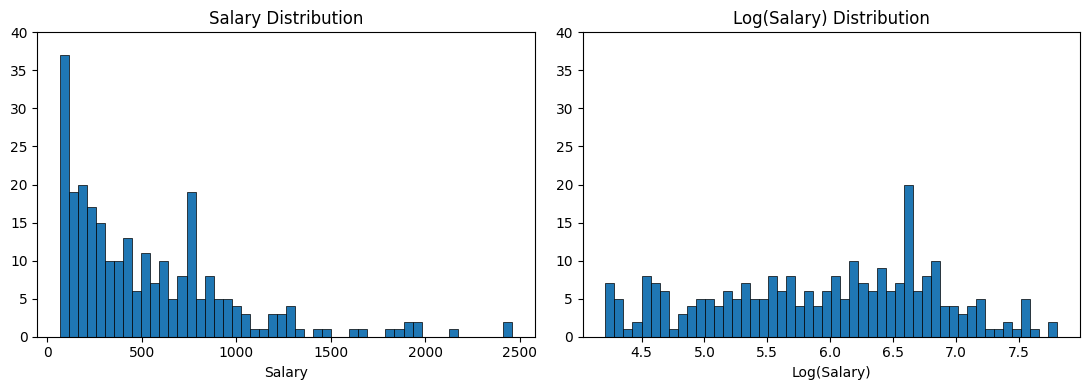

In [ ]:
X = df[['Years', 'Hits']].values
y = np.log(df.Salary.values )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# 'Salary' histogram
ax1.hist(df.Salary.values, bins=50, edgecolor='black', linewidth=0.5)
ax1.set_ylim(0, 40)
ax1.set_xlabel('Salary')
ax1.set_title('Salary Distribution')

# 'Log(Salary)' histogram
ax2.hist(y, bins=50, edgecolor='black', linewidth=0.5)
ax2.set_ylim(0, 40)
ax2.set_xlabel('Log(Salary)')
ax2.set_title('Log(Salary) Distribution')

plt.tight_layout()
plt.show()

Now we use the ``train_test_split`` function to split our dataset into the ``X`` and ``y`` matrixes/vectors for training and test sets. We set a seed that equals to ``0`` to ensure reproductibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We initiate a Decision Tree Regressor model, configuring the maximum number of final leaves it should contain in the ``max_leaf_nodes`` parameter. Following this configuration, we proceed to fit the model to our training data. We can change the ``max_leaf_nodes`` to different values.

In [ ]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=3)

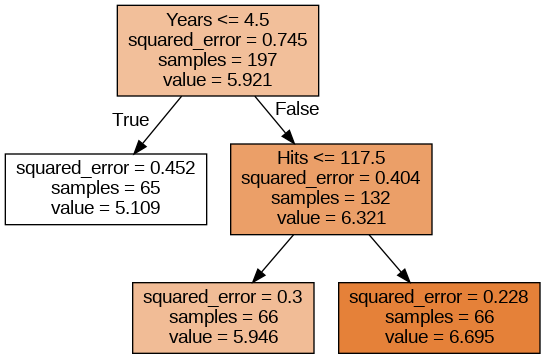

In [ ]:
graph, = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

This scatter plot visualizes observations in the 'Years' versus 'Hits' space, segmented into three distinct regions (R1, R2, R3) by the Decision Tree with three terminal leaves.

Text(11, 170, 'R3')

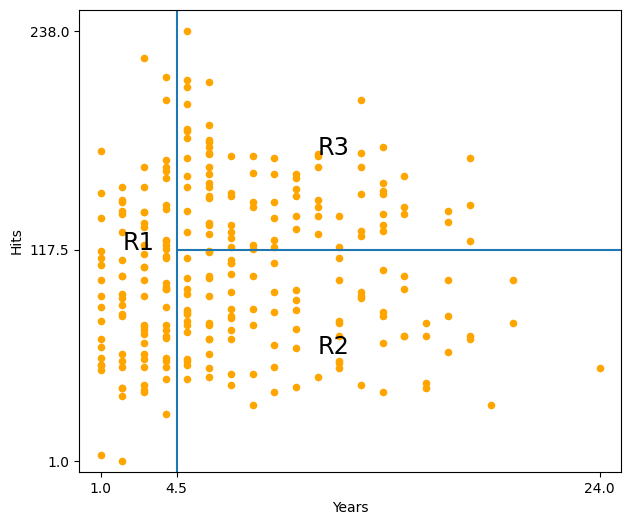

In [ ]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large')

## 3. Prunning

Pruning is a technique used in decision trees to reduce the size of the tree by removing sections (branches or leaves) that provide little to no power in classifying instances, aiming to reduce overfitting and improve the model's generalization capabilities.

Let's visualize how the model complexity reduces as the tree is pruned until an optimal value for ``alpha`` is found. First, let's fit the ``DecisionTreeRegressor`` with 15 final leaves

In [ ]:
regr = DecisionTreeRegressor(max_leaf_nodes=15)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=15)

Now let's compute de Cost Complexity Pruning Path, that presents how ``impurity`` in the leaves changes as the values of ``alpha`` increase:

- ``ccp_alphas:`` Array of alpha values for each step of the pruning. It accounts for the strenght of the prunning process.
- i``mpurities:`` Total impurity of leaves for each step of the pruning. It measures how different are observations in the final leaves.

In [ ]:
path = regr.cost_complexity_pruning_path( X, y )
ccp_alphas, impurities = path.ccp_alphas, path.impurities

This plot illustrates the relationship between Total Impurity Values and Alpha Values. Lower impurity indicates a more complex model, characterized by a larger number of leaves and minimal variation within each leaf. Conversely, as alpha rises, impurity also increases, which means a decrease in model complexity.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

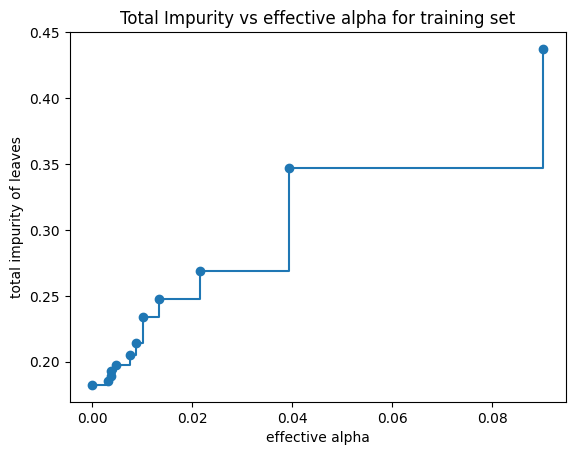

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Now let's visualize how different levels of pruning affect the complexity of decision tree models, as reflected by the number of nodes and the depth of the trees. First let's train ``DecisionTreeRegressor`` models for all the ``ccp_alpha `` values obtained in the last step

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Now let's plot the number of nodes and the depth of the nodes vs. the alpha parameters. We remove the last element from the list of classifiers and alpha values, because the last tree is the fully pruned tree (a single node).

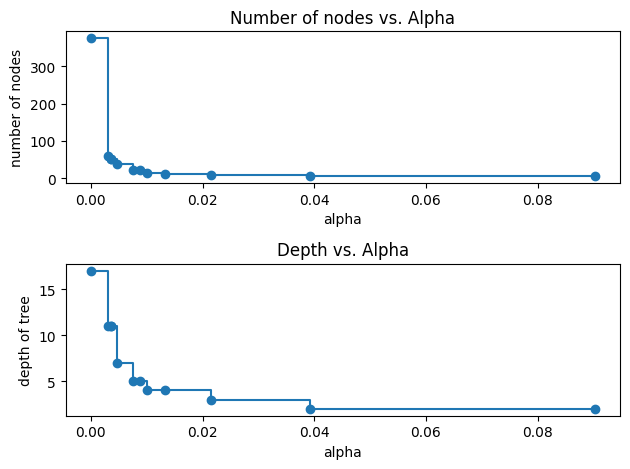

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs. Alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs. Alpha")
fig.tight_layout()

Now let's plot the Coefficient of determination vs. the Alpha values for traning and test sets. Consider that low alpha values tend to overfitting (see test set performance).

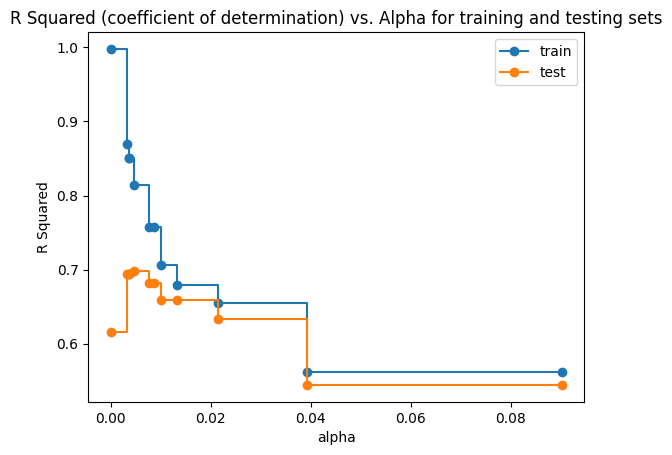

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("R Squared")
ax.set_title("R Squared (coefficient of determination) vs. Alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

## 4. Classification trees

Let's use the ``heart`` database to predict the likelikood of experiencing a heart attack

In [ ]:
df2 = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


We convert categorical variables into numerical form by factorizing them. This process involves mapping each unique category to a corresponding numerical value.

In [ ]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]
df2.AHD = pd.factorize(df2.AHD)[0]

  Let's split our data into the training and test sets in a Pythonic way

In [ ]:
target = [ 'AHD' ]
predictors = [ var for var in df2.columns if var not in target ]

X_train, X_test, y_train, y_test = train_test_split(df2[predictors], df2[target], test_size=0.5, random_state=0)

Now we fit a ``DecisionTreeClassifier``. Let's only set the ``max_depth`` parameter that accounts for the maximun number of levels our tree will have

In [ ]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

We visualize our model

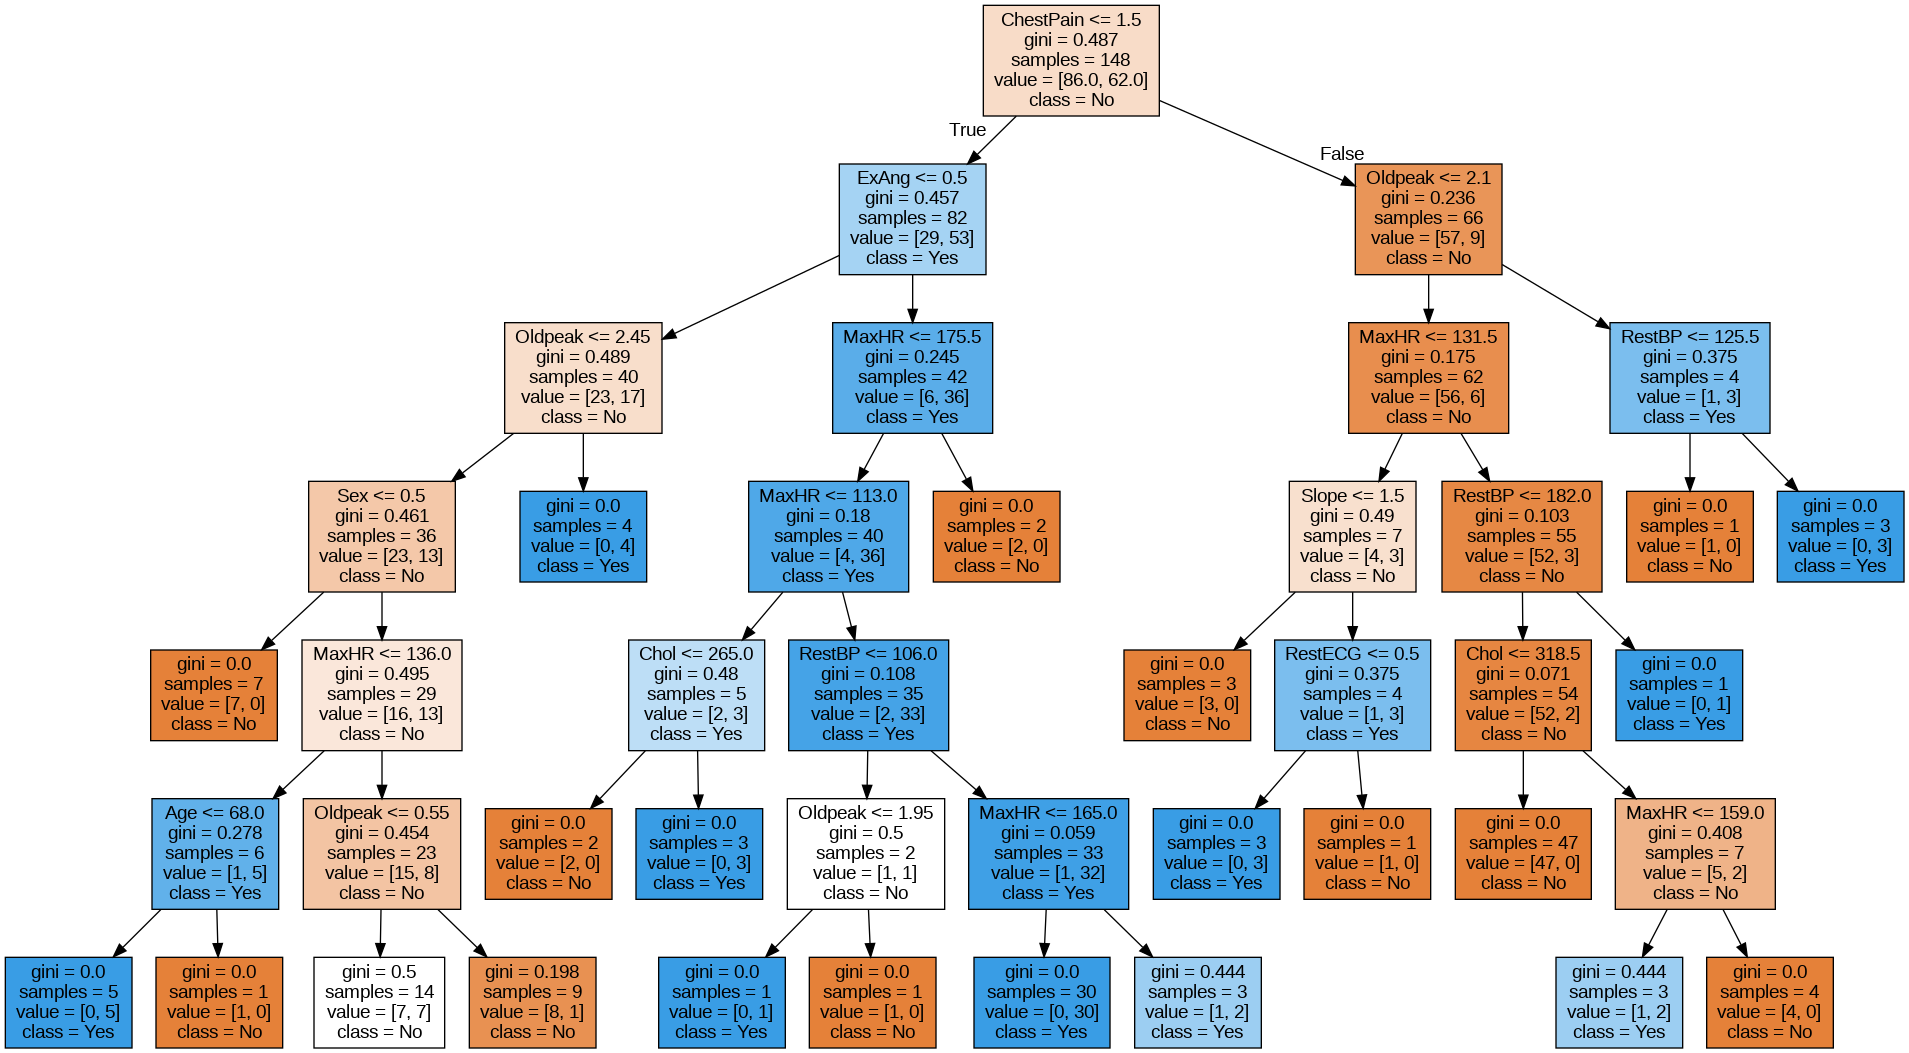

In [ ]:
graph2, = print_tree(clf, features=predictors, class_names=['No', 'Yes'])
Image(graph2.create_png())

And we can make predictions over the ``X_test`` set using the ``predict`` method

In [ ]:
y_pred = clf.predict(X_test)

Now let's print the Confussion Matrix

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
print(cm)

True       No  Yes
Predicted         
No         63   37
Yes        11   38


And we can get a Classification Report that shows different classification performance metrics such as ``Accuracy``, ``Precision``, ``Recall`` and ``F1``

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72        74
           1       0.78      0.51      0.61        75

    accuracy                           0.68       149
   macro avg       0.70      0.68      0.67       149
weighted avg       0.70      0.68      0.67       149



## 5. Regression Trees

Let's use the Boston dataset to predict crime rates

In [ ]:
boston_df = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/boston.csv')

Let's divide in training and test sets

In [ ]:
target = [ 'medv' ]
predictors = [ var for var in boston_df.columns if var not in target ]

X_train, X_test, y_train, y_test = train_test_split(boston_df[predictors], boston_df[target], test_size=0.5, random_state=0)

We need an unidimensional unidimensional vector for the ``Ys``

In [ ]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

Now we can fit the models and graph

In [ ]:
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
y_pred = regr2.predict(X_test)

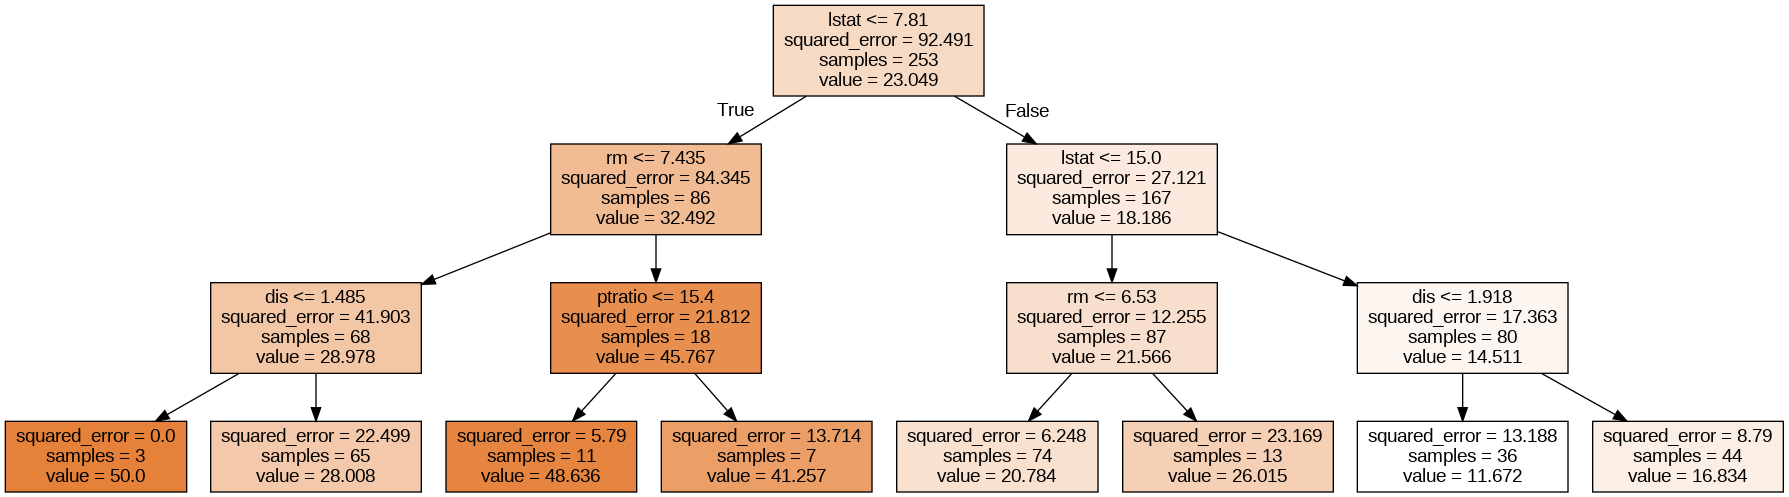

In [ ]:
graph3, = print_tree(regr2, features=predictors)
Image(graph3.create_png())

"Let's create a scatter plot to visualize the relationship between the predicted and actual values for the test set. In an ideal model, data points will align closely with the line ``y = x``, indicating perfect predictions. The closer the points are to this line, the more accurate the model is.

Text(0, 0.5, 'y_test')

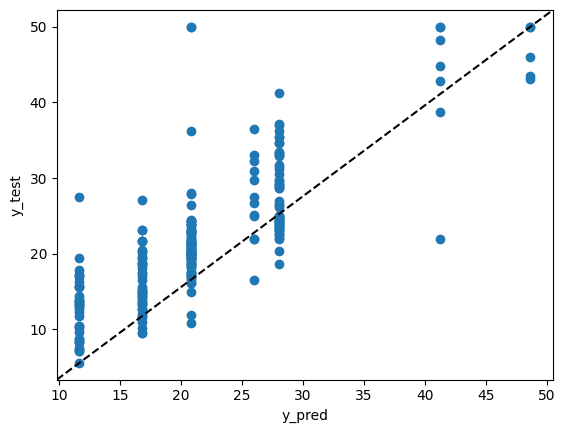

In [ ]:
plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')

We can compute the Mean Square Error and other performance metrics

In [ ]:
mse_dt = round( mean_squared_error(y_test, y_pred), 3 )
r2_dt = round( r2_score(y_test, y_pred), 3 )

In [ ]:
metrics_dt = pd.DataFrame({'Metric': ['Mean Squared Error (MSE)', 'R-squared (R2)'], 'Value': [mse_dt, r2_dt]})
metrics_dt

,Metric,Value
0,Mean Squared Error (MSE),26.023
1,R-squared (R2),0.657


## 6. Bagging

In [ ]:
bagging = BaggingRegressor(max_features=13, random_state=1)
bagging.fit(X_train, y_train)

BaggingRegressor(max_features=13, random_state=1)

Text(0, 0.5, 'y_test')

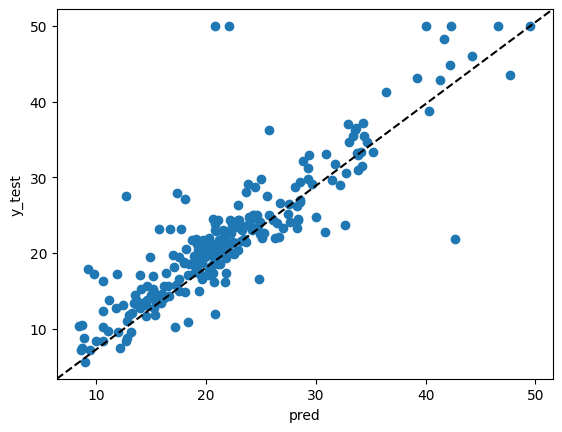

In [ ]:
y_pred = bagging.predict(X_test)

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
mse_bag = round( mean_squared_error(y_test, y_pred), 3 )
r2_bag = round( r2_score(y_test, y_pred), 3 )

metrics_bag = pd.DataFrame({
    'Model': ['Bagging'],
    'Mean Squared Error (MSE)': [mse_bag],
    'R-squared (R2)': [r2_bag]
})
metrics_bag

,Model,Mean Squared Error (MSE),R-squared (R2)
0,Bagging,18.273,0.759


## 7. Random Forest

In [ ]:
rf = RandomForestRegressor(max_features=13, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

Text(0, 0.5, 'y_test')

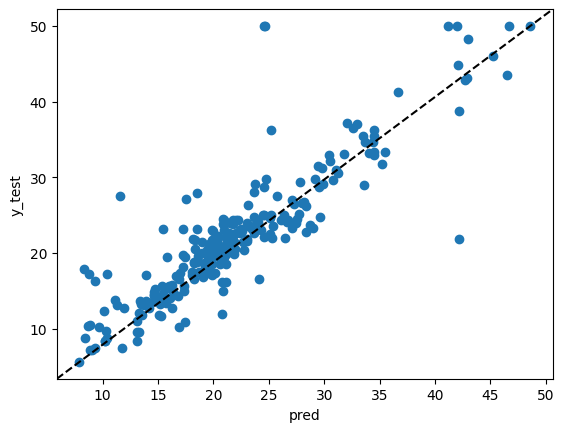

In [ ]:
y_pred = rf.predict(X_test)

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
mse_rf = round( mean_squared_error(y_test, y_pred), 3 )
r2_rf = round( r2_score(y_test, y_pred), 3 )

metrics_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'Mean Squared Error (MSE)': [mse_rf],
    'R-squared (R2)': [r2_rf]
})
metrics_rf

,Model,Mean Squared Error (MSE),R-squared (R2)
0,Random Forest,16.249,0.786


We can visualize the importance of variables by leveraging the ``feature_importance`` attribute. This attribute quantifies each variable's contribution to the model based on the Gini Impurity Criteria, a metric that shows the variable's influence on the model's decision-making process.

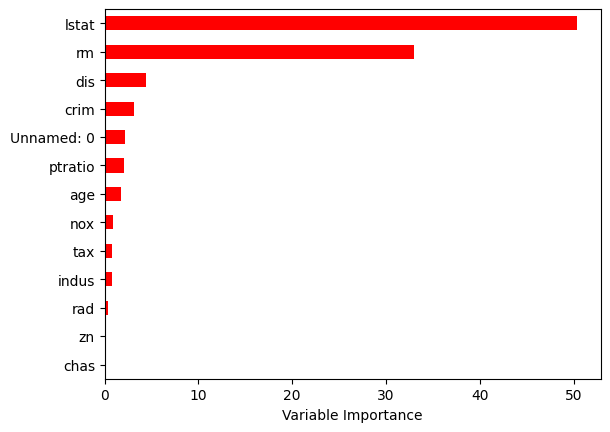

In [ ]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=predictors)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8. Gradient Boosting

In [ ]:
boost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=1)

Text(0, 0.5, 'y_test')

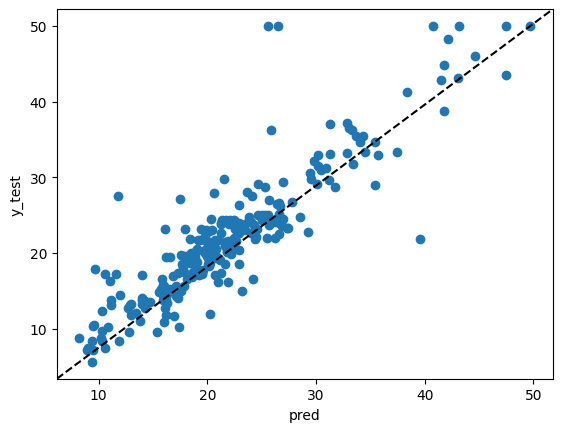

In [ ]:
y_pred = boost.predict(X_test)

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
mse_boost = round( mean_squared_error(y_test, y_pred), 3 )
r2_boost = round( r2_score(y_test, y_pred), 3 )

metrics_boost = pd.DataFrame({
    'Model': ['Gradient Boosting Regressor'],
    'Mean Squared Error (MSE)': [mse_boost],
    'R-squared (R2)': [r2_boost]
})
metrics_boost

,Model,Mean Squared Error (MSE),R-squared (R2)
0,Gradient Boosting Regressor,15.257,0.799


Let's compare the metrics for all the models

In [ ]:
metrics_combined = pd.concat([metrics_bag, metrics_rf, metrics_boost])
metrics_combined = metrics_combined.sort_values('R-squared (R2)', ascending=False).reset_index(drop=True)
metrics_combined

,Model,Mean Squared Error (MSE),R-squared (R2)
0,Gradient Boosting Regressor,15.257,0.799
1,Random Forest,16.249,0.786
2,Bagging,18.273,0.759


## 9. Grid search

A grid search for hyperparameter tuning on three different regression models: Random Forest Regressor, Bagging, and Gradient Boosting Regressor.

First, the three models are defined with their respective names, estimator objects, and a dictionary of parameters. The parameters include ``n_estimators``, ``max_depth``, and ``learning_rate`` where applicable.

In [ ]:
models = [
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    {
        'name': 'Bagging',
        'model': BaggingRegressor(),
        'params': {
            'n_estimators': [10, 20, 30],
            'estimator': [None, RandomForestRegressor(max_depth=10)]
        }
    },
    {
        'name': 'Gradient Boosting Regressor',
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10]
        }
    }
]

**Grid Search:**

- For each model, ``GridSearchCV`` is used to find the best combination of parameters based on cross-validation. The scoring is based on Mean Squared Error.

**Model evaluation:**
- The best model from each grid search is used to make predictions on the test set (X_test).
- The performance of each model is evaluated using Mean Squared Error (MSE) and R-squared (R2), two common metrics for regression analysis. The results are rounded to three decimal places for readability.
- Results are stored in a list of dictionaries.

In [ ]:
results = []

for model in models:
    grid = GridSearchCV(model['model'], model['params'], cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model['name'],
        'MSE': round(mse, 3),
        'R Squared': round(r2, 3),
        'Best Params': grid.best_params_
    })

Finally we convert the list of dictionaries into a pandas DataFrame

In [ ]:
df_results = pd.DataFrame(results).sort_values('R Squared', ascending=False).reset_index(drop=True)
df_results

,Model,MSE,R Squared,Best Params
0,Gradient Boosting Regressor,15.167,0.800,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
1,Bagging,16.368,0.784,{'estimator': RandomForestRegressor(max_depth=...
2,Random Forest Regressor,16.509,0.782,"{'max_depth': 10, 'n_estimators': 50}"
